In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import *
from keras.models import Model

from keras import backend as K

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.Session()
tf.keras.backend.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)


batch_size = 64
latent_dim = 8
num_classes = 10
shape = (28, 28, 1)
gamma = 1



def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)


11490434/11490434 [==============================] - 2s 0us/step


In [3]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='image')
y_ = tf.placeholder(tf.float32, shape=(None, 10), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

In [4]:
x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
x = LeakyReLU()(x)
x = MaxPool2D((2, 2), padding='same')(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = LeakyReLU()(x)

x = Flatten()(x)
x = concatenate([x, lbl])

h = Dense(64)(x)
h = LeakyReLU()(h)

z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(K.clip(z_log_var/2, -2, 2)) * epsilon
l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model([img, lbl], [z_mean, z_log_var, l], name='Encoder')

In [5]:
x = concatenate([z, lbl])
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7, 7, 128))(x)
x = UpSampling2D(size=(2, 2))(x)

x = Conv2D(64, kernel_size=(5, 5), padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = LeakyReLU()(x)

decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
decoder = Model([z, lbl], decoded, name='Decoder')

In [6]:
x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
x = MaxPool2D((2, 2), padding='same')(x)
x = LeakyReLU()(x)

repeat = RepeatVector(int(x.shape[1]) * int(x.shape[2]))(lbl)
repeat = Reshape((x.shape[1], x.shape[2], lbl.shape[1]))(repeat)
x = concatenate([x, repeat])

x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = LeakyReLU()(x)

l = Conv2D(16, kernel_size=(3, 3), padding='same')(x)
x = LeakyReLU()(x)

h = Flatten()(x)
d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], [d, l], name='Discriminator')

In [7]:
z_mean, z_log_var, encoded_img = encoder([img, lbl])

decoded_img = decoder([encoded_img, lbl])
decoded_z   = decoder([z, lbl])

discr_img,     discr_l_img     = discrim([img, lbl])
discr_dec_img, discr_l_dec_img = discrim([decoded_img, lbl])
discr_dec_z,   discr_l_dec_z   = discrim([decoded_z, lbl])

cvae_model = Model([img, lbl], decoder([encoded_img, lbl]), name='cvae')
cvae =  cvae_model([img, lbl])

In [8]:
L_prior = -0.5*tf.reduce_sum(1. + tf.clip_by_value(z_log_var, -2, 2) - tf.square(z_mean) - tf.exp(tf.clip_by_value(z_log_var, -2, 2)))/28/28

log_dis_img = tf.log(discr_img + 1e-10)
log_dis_dec_z = tf.log(1. - discr_dec_z + 1e-10)
log_dis_dec_img = tf.log(1. - discr_dec_img + 1e-10)

L_GAN = -1/4*tf.reduce_sum(log_dis_img + 2*log_dis_dec_z + log_dis_dec_img)/28/28

L_dis_llike = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.sigmoid(discr_l_img),
                                                                    logits=discr_l_dec_img))/28/28

L_enc = L_dis_llike + L_prior
L_dec = gamma * L_dis_llike - L_GAN
L_dis = L_GAN


opt_enc = tf.train.RMSPropOptimizer(0.001)
opt_dec = tf.train.RMSPropOptimizer(0.0001)
opt_dis = tf.train.RMSPropOptimizer(0.001)


step_enc = opt_enc.minimize(L_enc, var_list=encoder.trainable_weights)
step_dec = opt_dec.minimize(L_dec, var_list=decoder.trainable_weights)
step_dis = opt_dis.minimize(L_dis, var_list=discrim.trainable_weights)


def step(image, label, zp):
    l_prior, dec_image, l_dis_llike, l_gan, _, _ = sess.run([L_prior, decoded_z, L_dis_llike, L_GAN, step_enc, step_dec],
                                                            feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_prior, dec_image, l_dis_llike, l_gan

def step_d(image, label, zp):
    l_gan, _ = sess.run([L_GAN, step_dis], feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_gan


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [74]:
def display_digits():
    n = 10
    num = 2
    b = next(test_batches_it)

    decoded = sess.run(cvae, feed_dict={img:b[0], lbl:b[1], K.learning_phase():0})


    digit_size = 28

    figure = np.zeros((digit_size * num, digit_size * n))

    for i in range(n):
        for j in range(num):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = b[0][:n][i].reshape(digit_size, digit_size) if j == 0 else decoded[i].reshape(digit_size, digit_size)


    plt.figure(figsize=(2*n, 2*num))
    plt.imshow(figure, cmap='Greys_r')

    plt.show()

(64, 10)


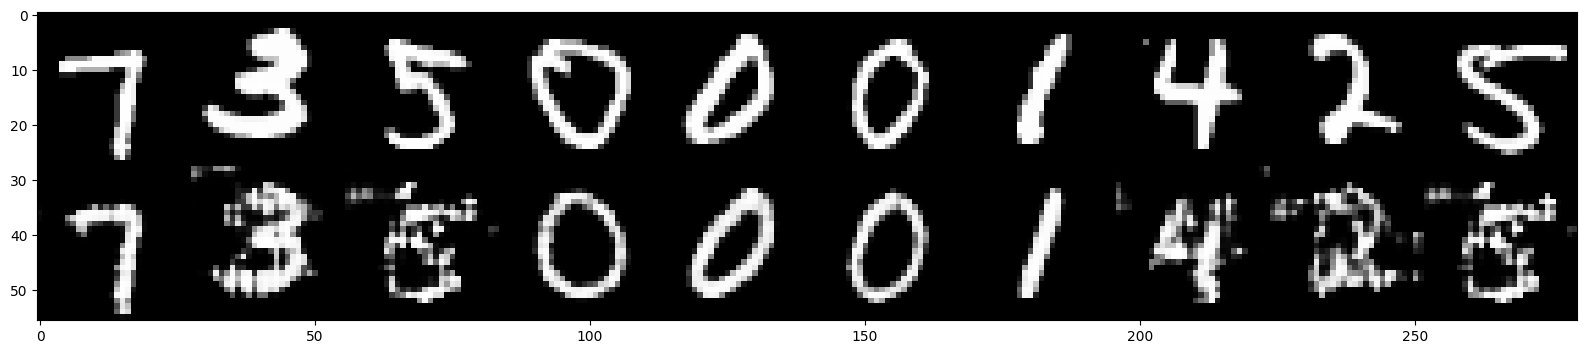

In [38]:
display_digits()

In [69]:
def display_z(my_label = 0):
    n = 1
    num = 1

    zp = np.random.randn(1, latent_dim)

    my_label_one = [[0 for i in range(10)]]
    my_label_one[0][my_label] = 1

    decoded = sess.run([decoded_z], feed_dict={z:zp, lbl:my_label_one, K.learning_phase():0})

    digit_size = 28

    figure = np.zeros((digit_size * num, digit_size * n))

    for i in range(n):
        figure[0: digit_size,
                   i * digit_size: (i + 1) * digit_size] = decoded[i].reshape(digit_size, digit_size)


    plt.figure(figsize=(2*n, 2*num))
    plt.imshow(figure, cmap='Greys_r')

    plt.show()

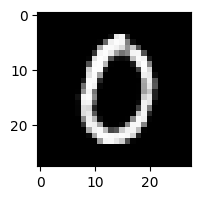

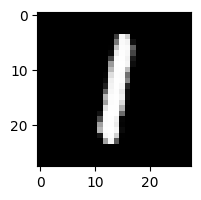

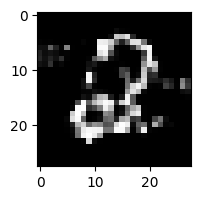

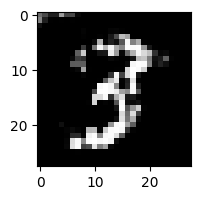

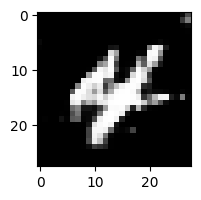

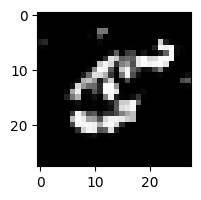

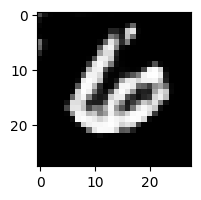

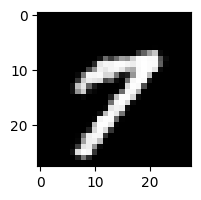

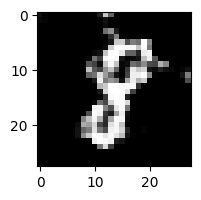

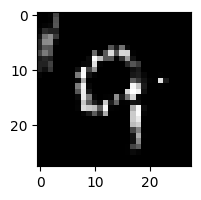

In [73]:
display_z(0)
display_z(1)
display_z(2)
display_z(3)
display_z(4)
display_z(5)
display_z(6)
display_z(7)
display_z(8)
display_z(9)

In [10]:
sess.run(tf.global_variables_initializer())

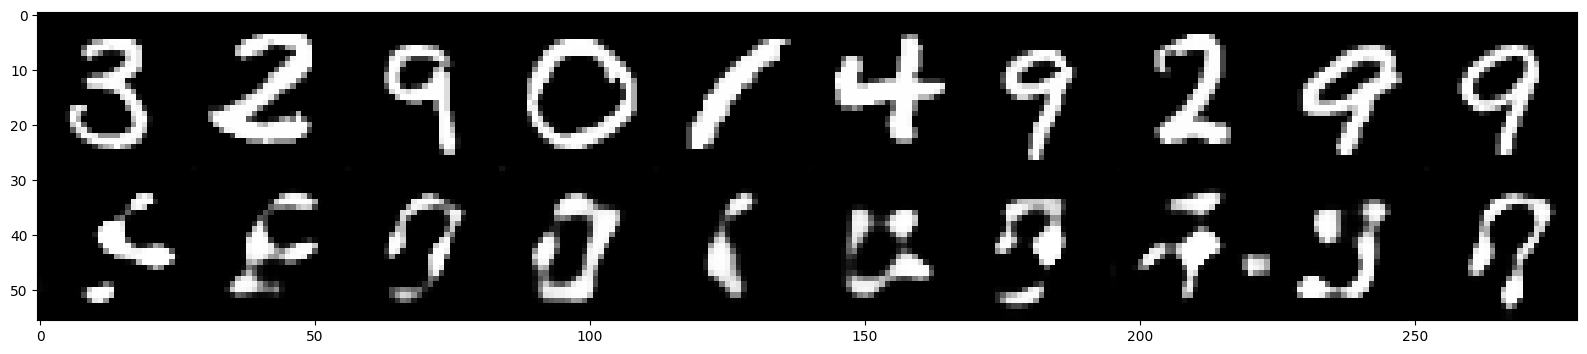

epochs:  0 loss:  8.03416e-06 14.400158 0.038956128


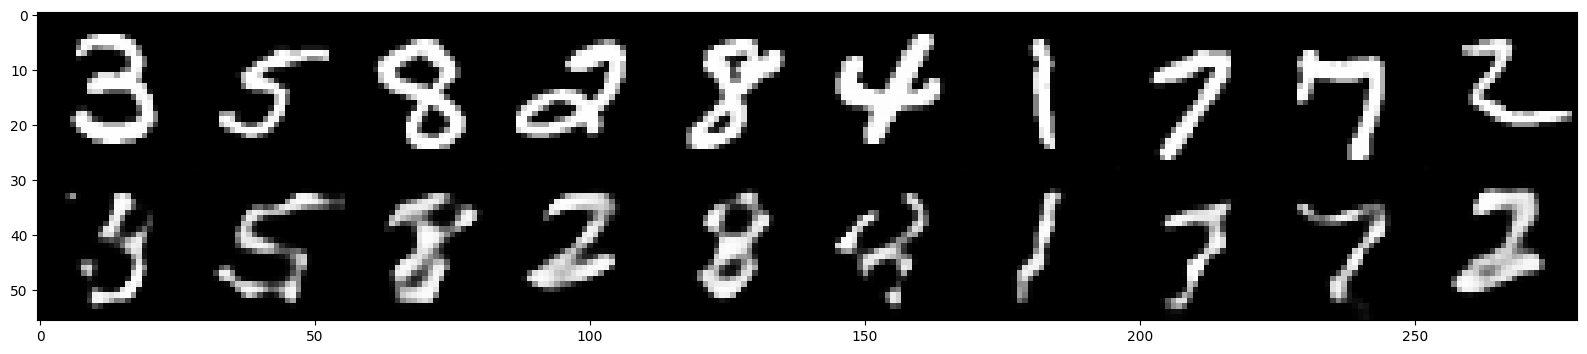

epochs:  1 loss:  0.00042435926 14.272135 0.03420899


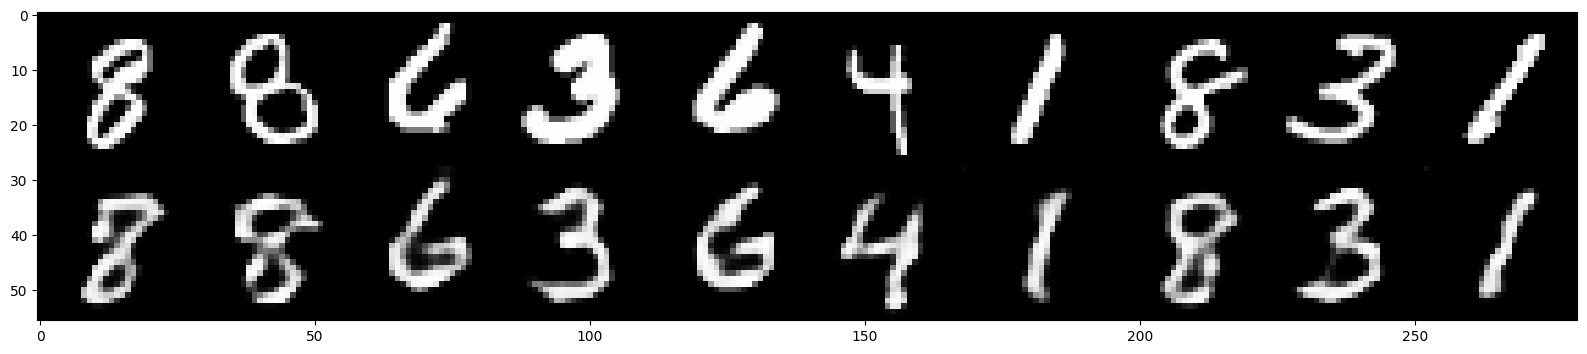

epochs:  2 loss:  0.0122018065 13.81842 0.016145084


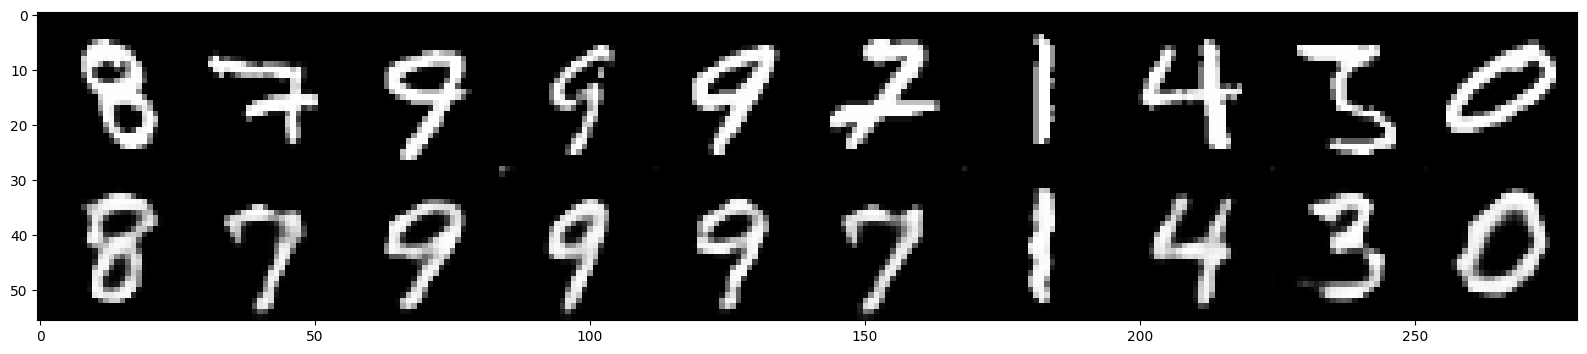

epochs:  3 loss:  0.030383216 13.380876 0.0064084637


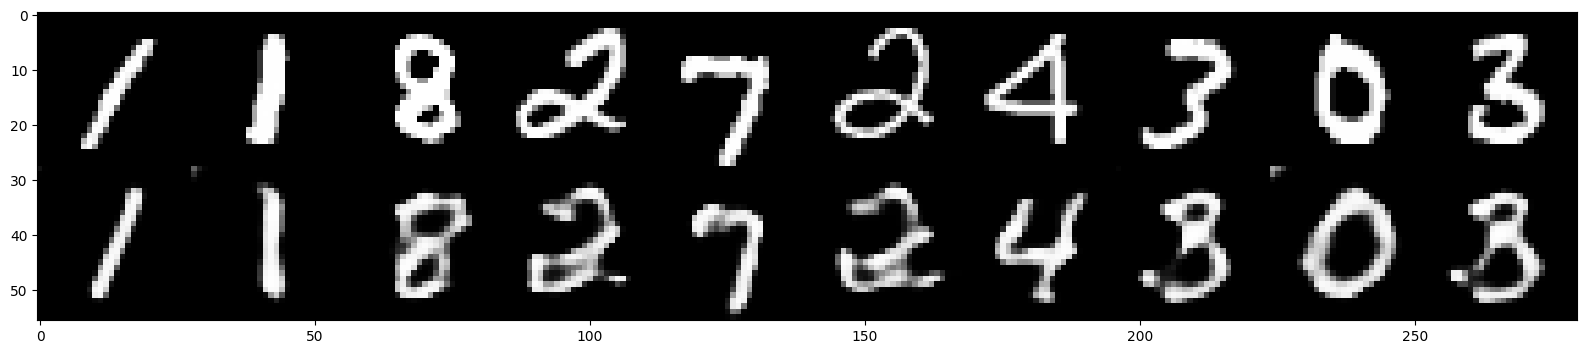

epochs:  4 loss:  0.03747557 13.227947 0.0062491386


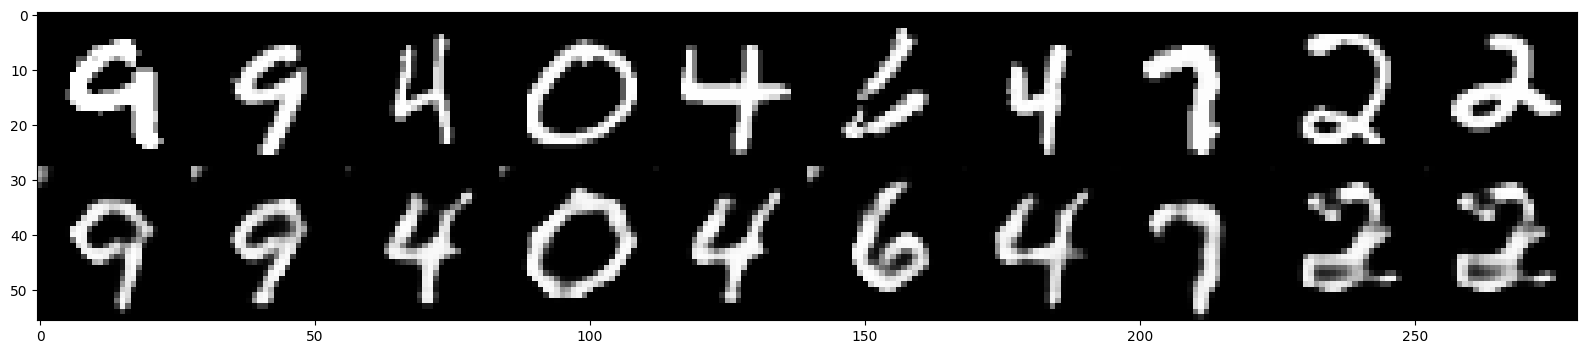

epochs:  5 loss:  0.056924827 12.7930765 0.0027124926


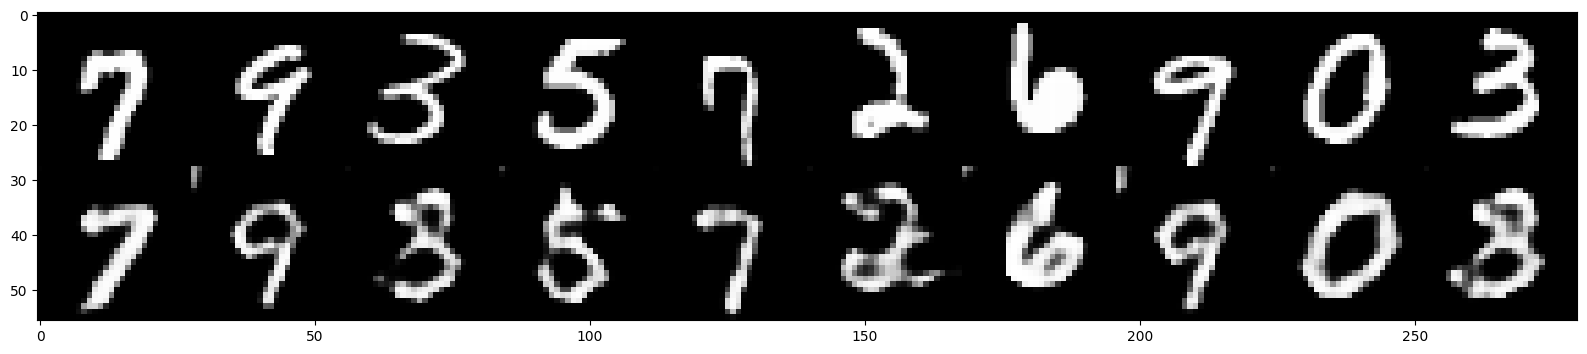

epochs:  6 loss:  0.07173857 12.937021 0.0033610496


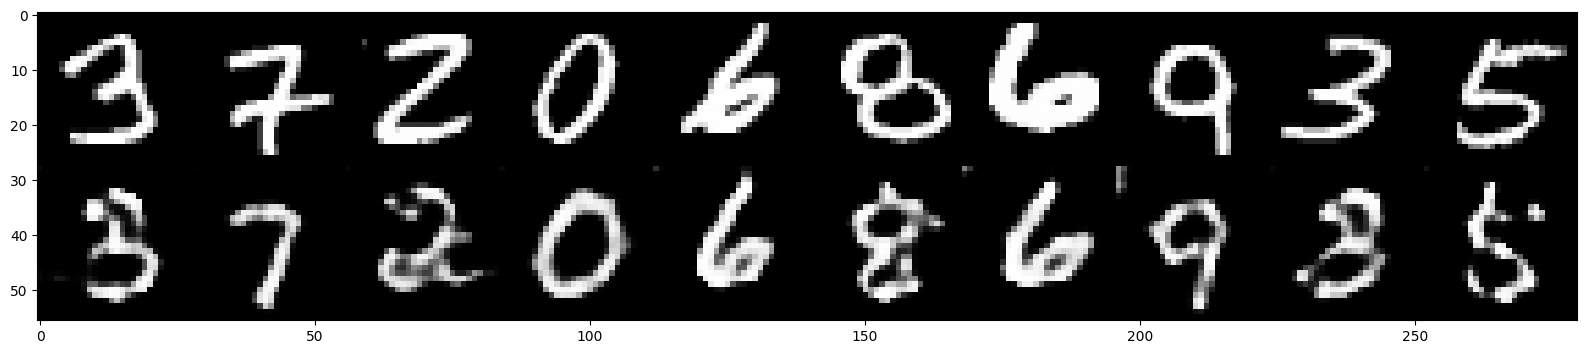

epochs:  7 loss:  0.07793038 12.806459 0.0044547454


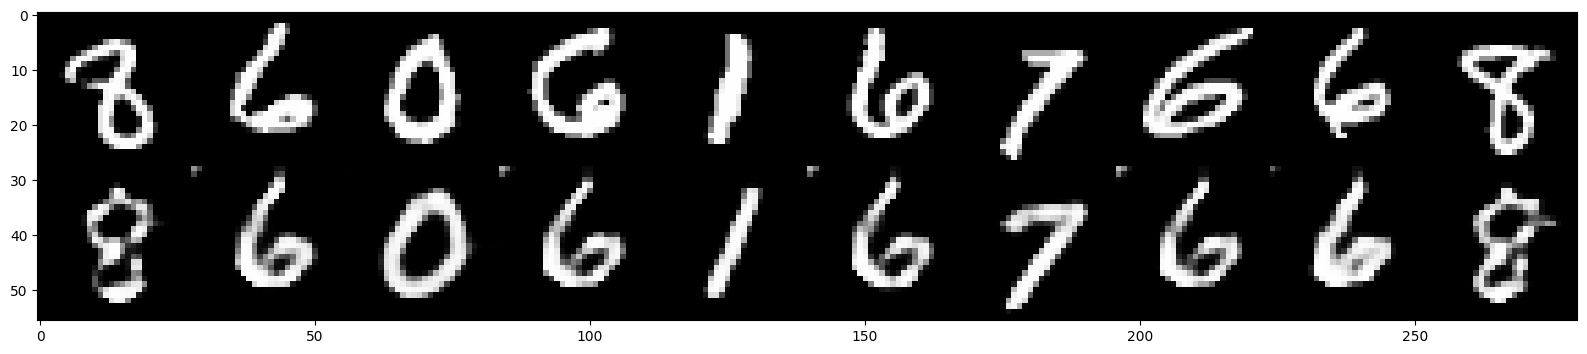

epochs:  8 loss:  0.098019294 12.822079 0.011249857


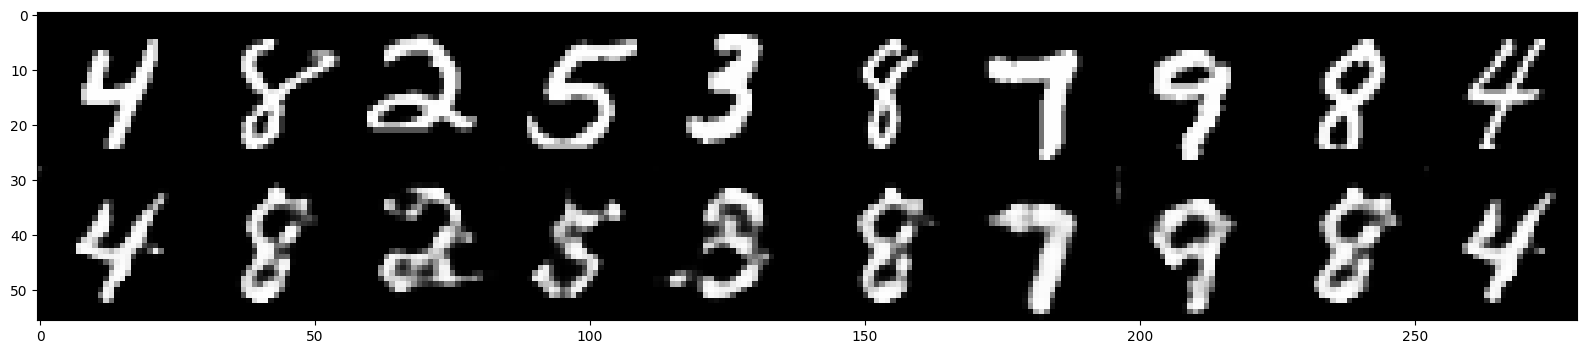

epochs:  9 loss:  0.086738974 12.583579 0.002917925


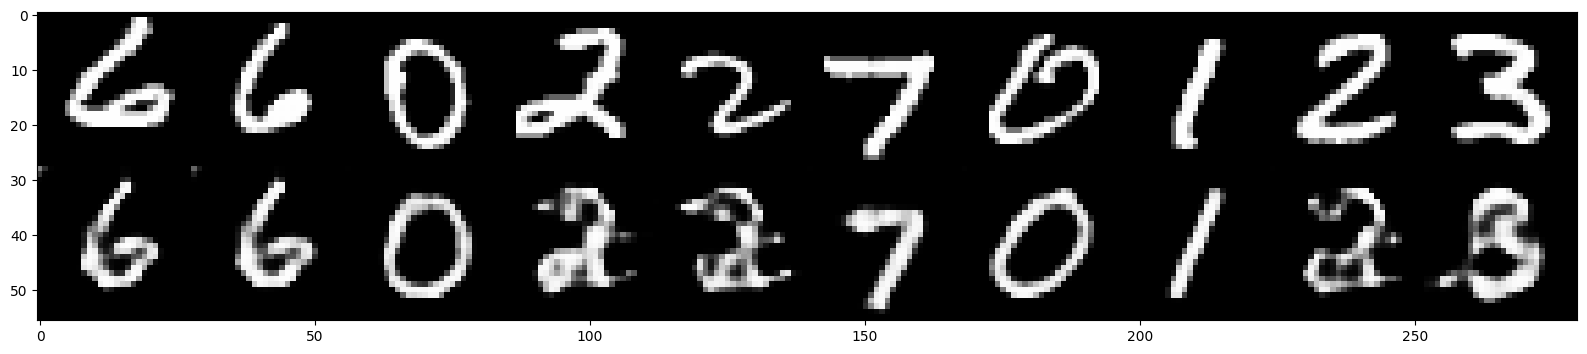

epochs:  10 loss:  0.100251675 12.58893 0.0033169081


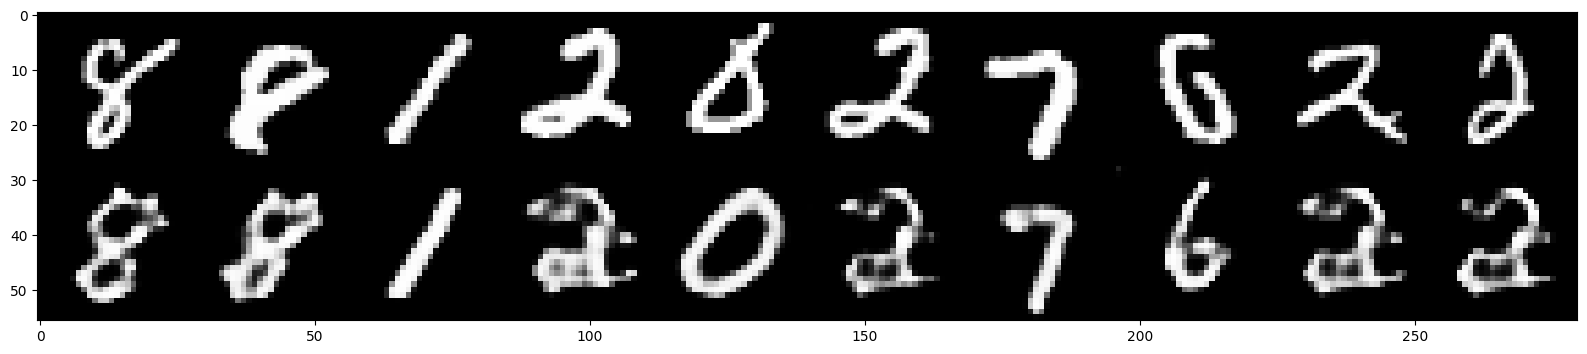

epochs:  11 loss:  0.123674564 12.524947 0.0052773464


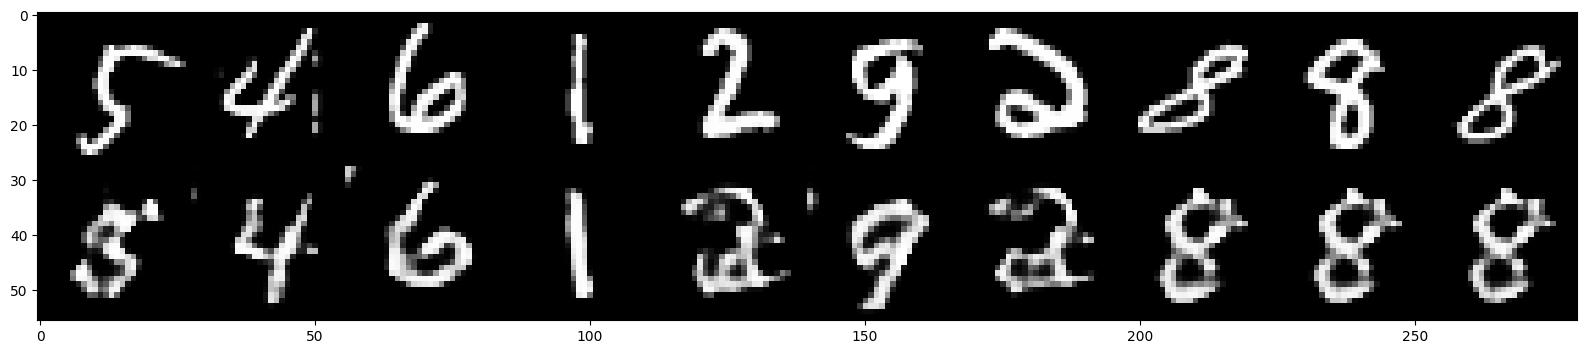

epochs:  12 loss:  0.09567965 12.639077 0.004101765


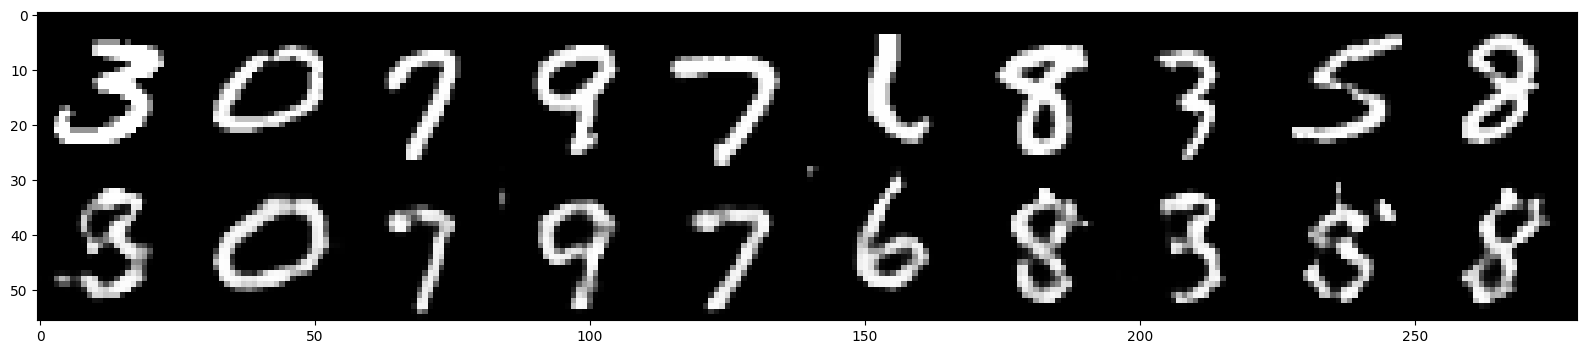

epochs:  13 loss:  0.118289135 12.317436 0.001666386


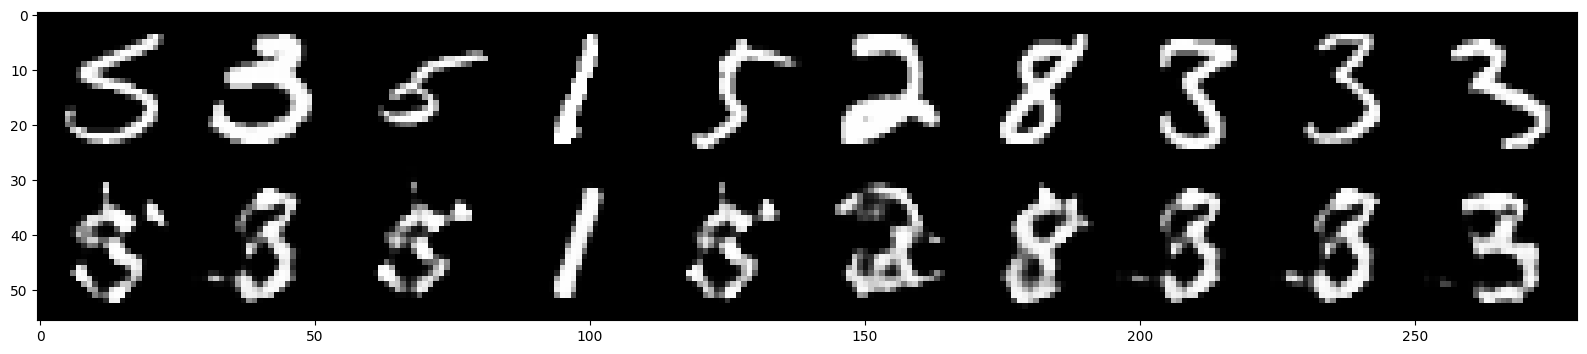

epochs:  14 loss:  0.11801641 12.33058 0.0045890347


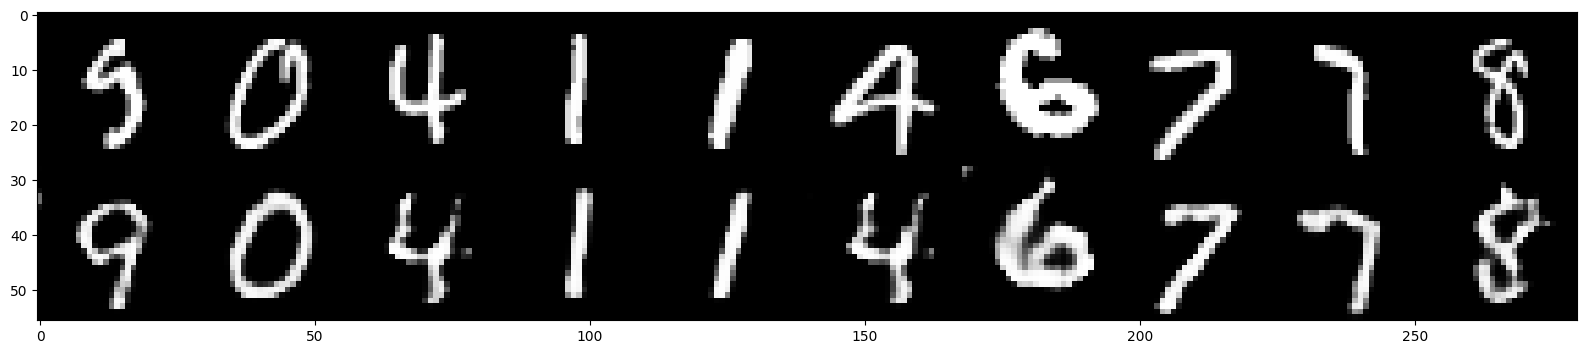

epochs:  15 loss:  0.12181317 12.279216 0.003054352


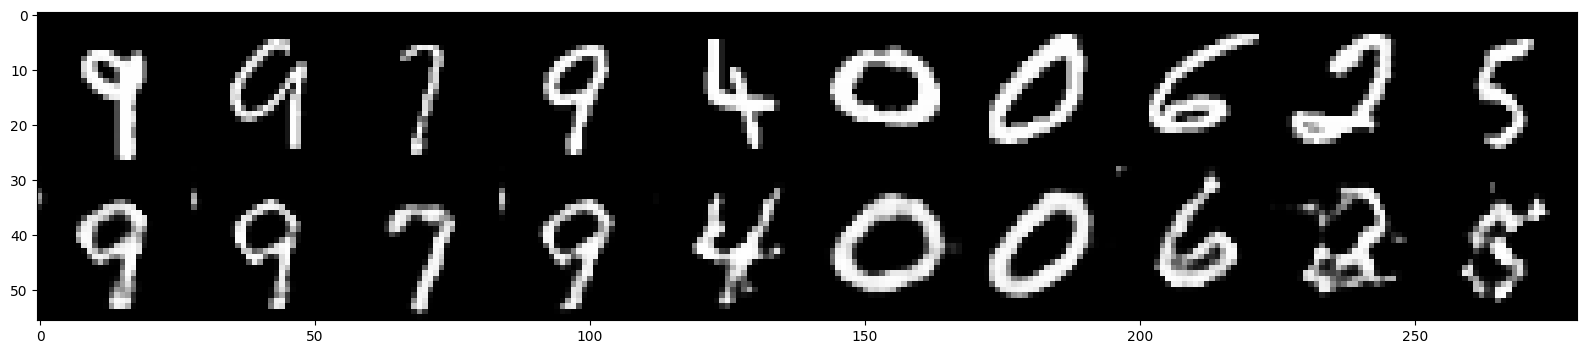

epochs:  16 loss:  0.13524556 12.411859 0.007798495


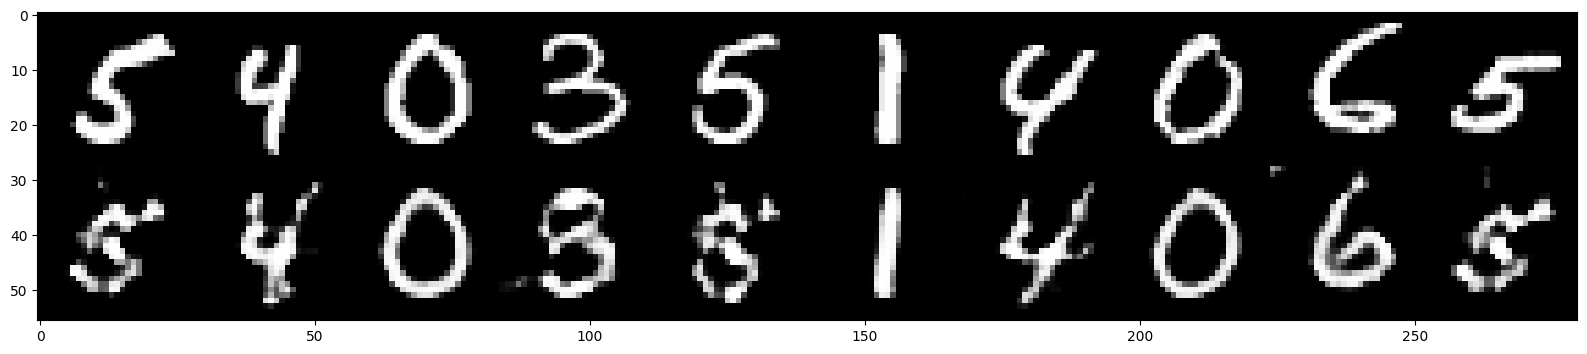

epochs:  17 loss:  0.12940936 12.109699 0.00088730775


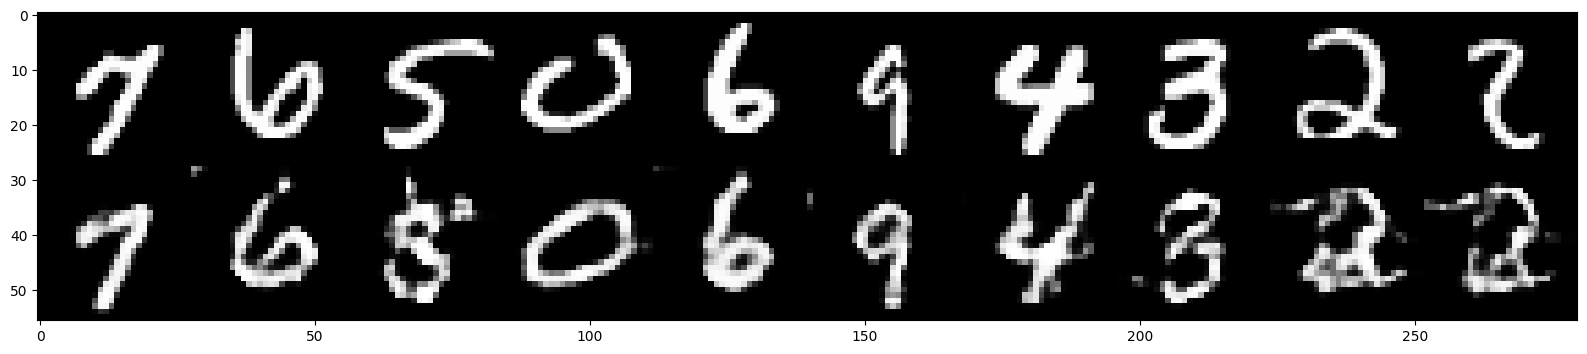

epochs:  18 loss:  0.13426147 12.173451 0.0038552715


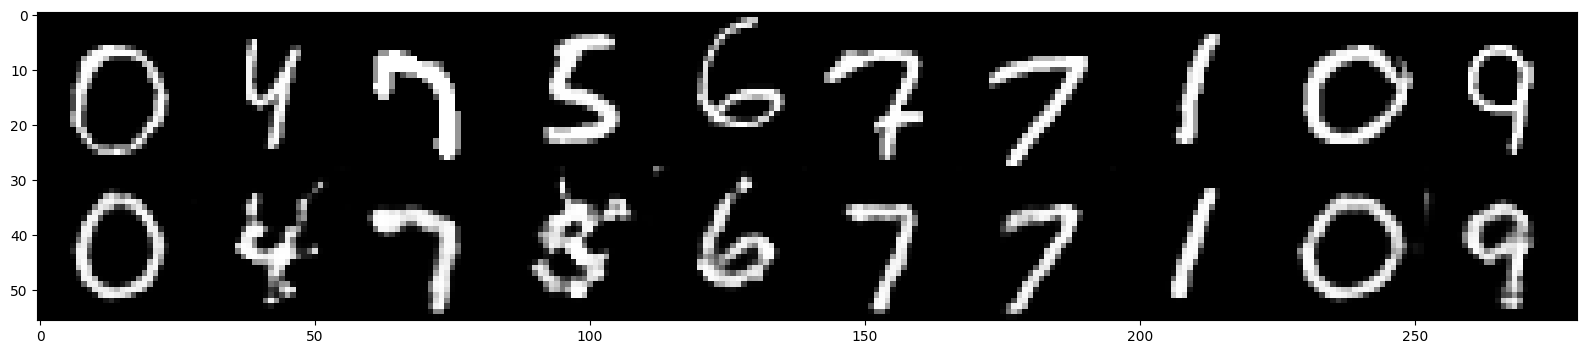

epochs:  19 loss:  0.13784248 12.1658945 0.0013606023


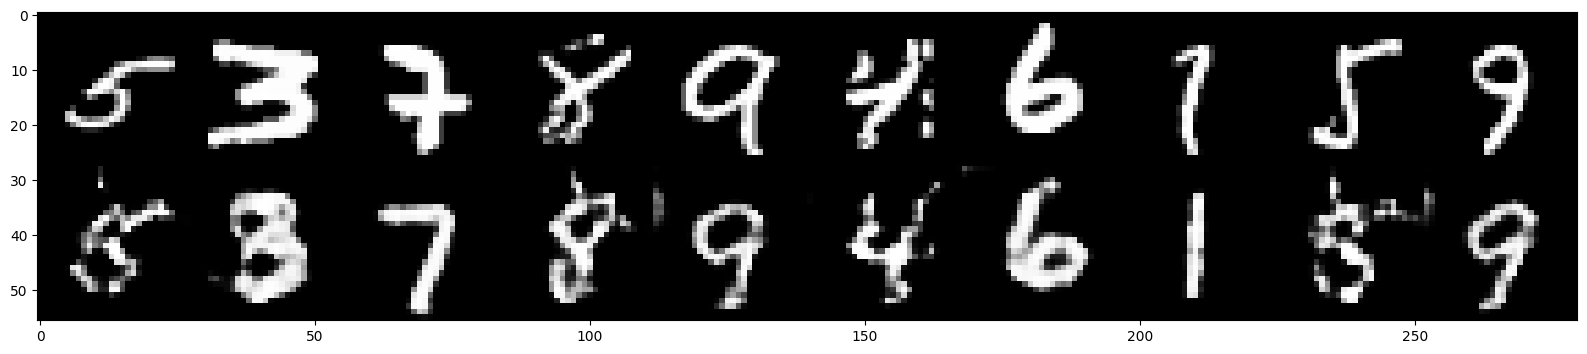

epochs:  20 loss:  0.14270279 12.175588 0.0034927859


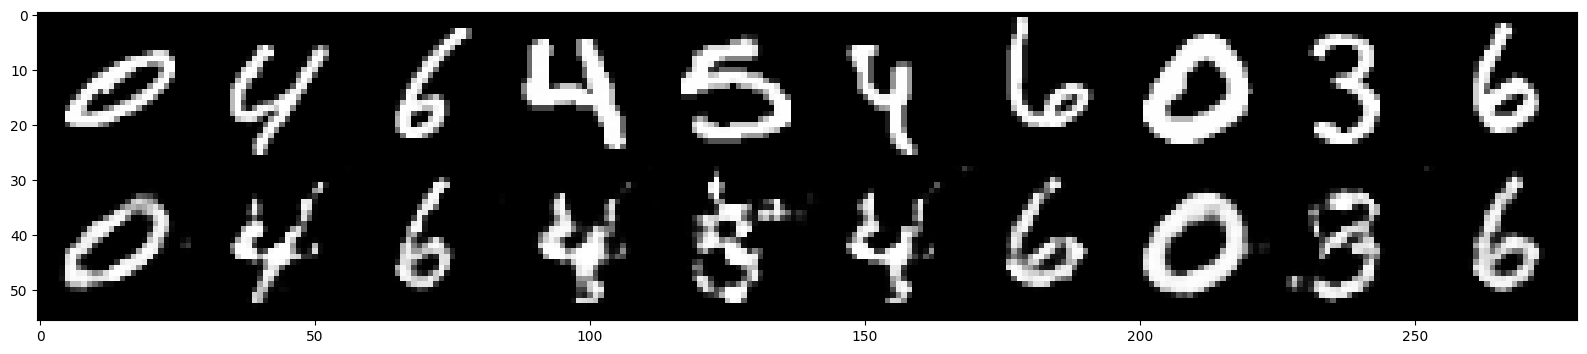

epochs:  21 loss:  0.16119125 12.061769 0.0024663291


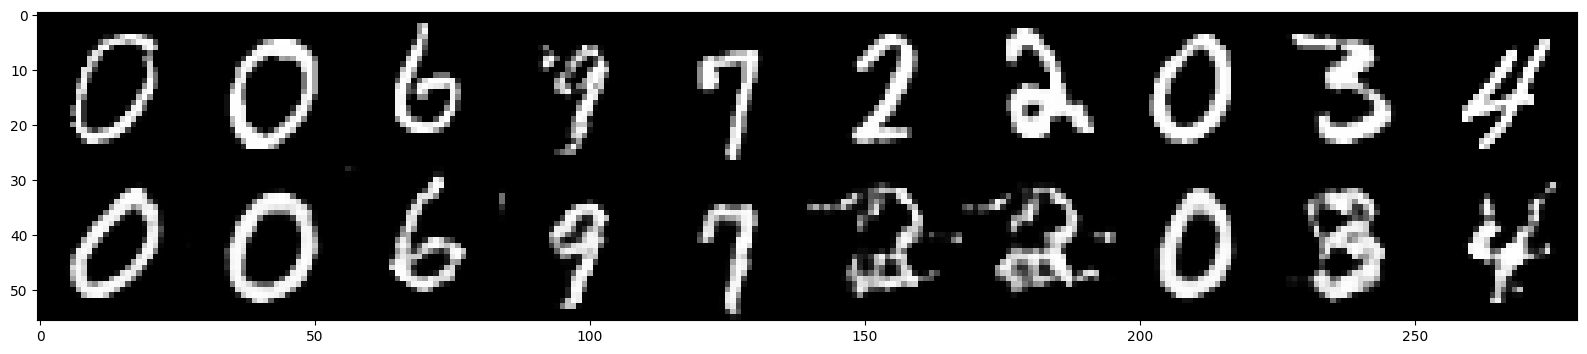

epochs:  22 loss:  0.15464981 12.077049 0.002507029


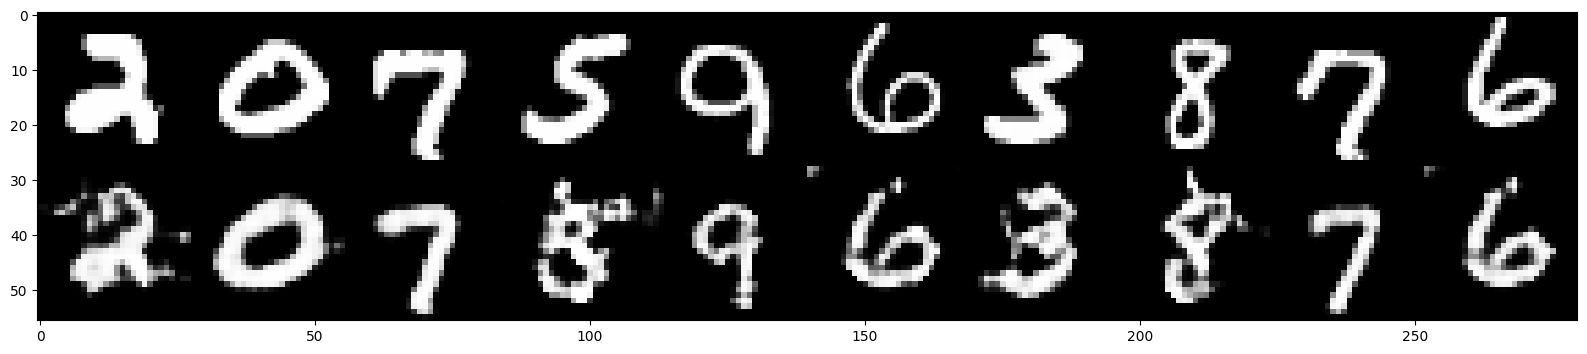

epochs:  23 loss:  0.16993418 11.972934 0.0016513243


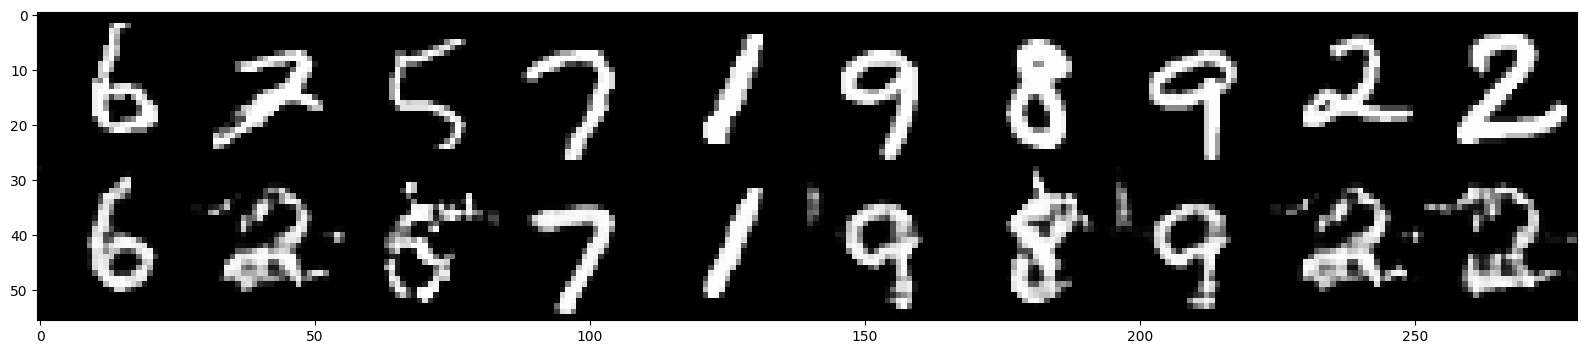

epochs:  24 loss:  0.1762661 12.178913 0.0035916946


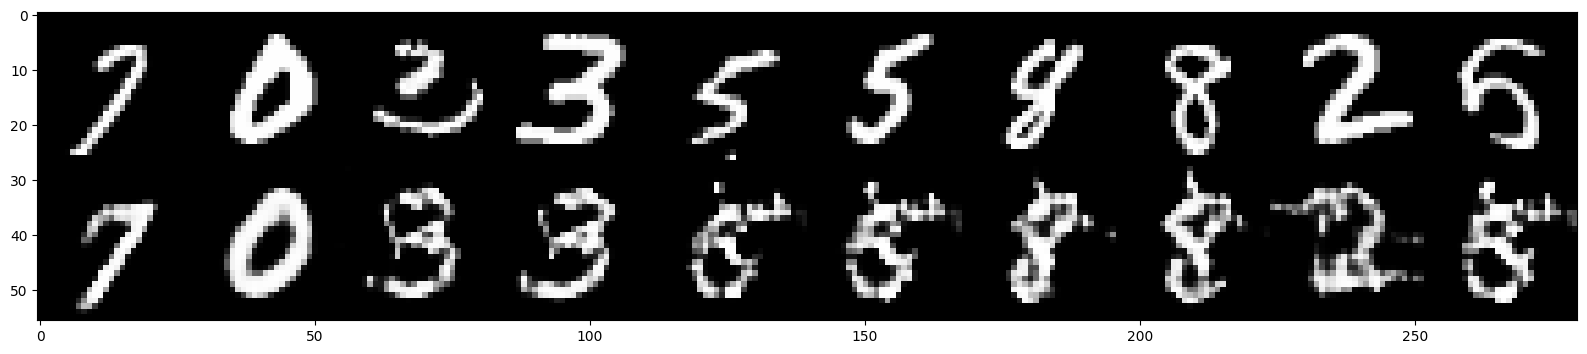

epochs:  25 loss:  0.15819322 11.937537 0.0016810806


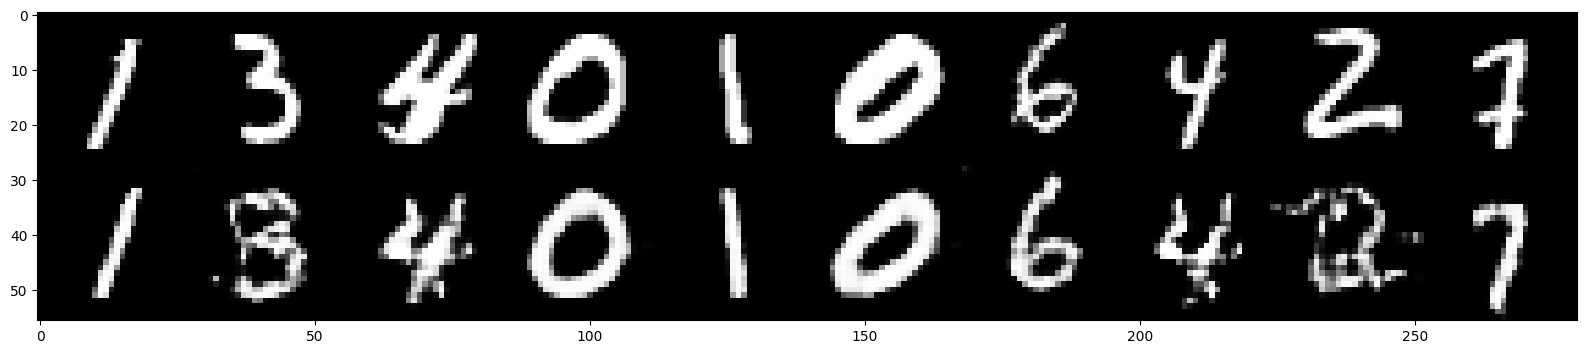

epochs:  26 loss:  0.16531305 11.815064 0.0020302995


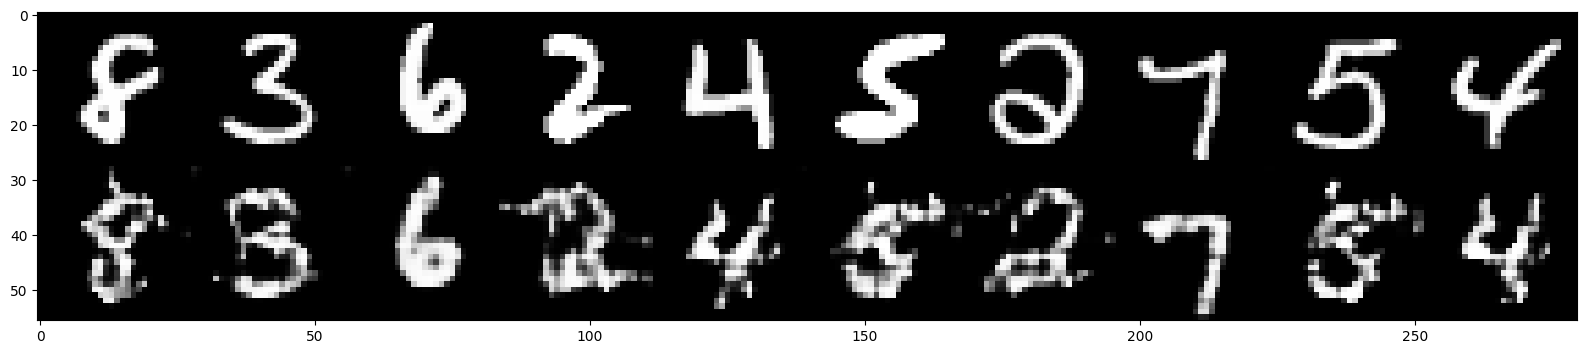

epochs:  27 loss:  0.1640991 12.011889 0.0029369893


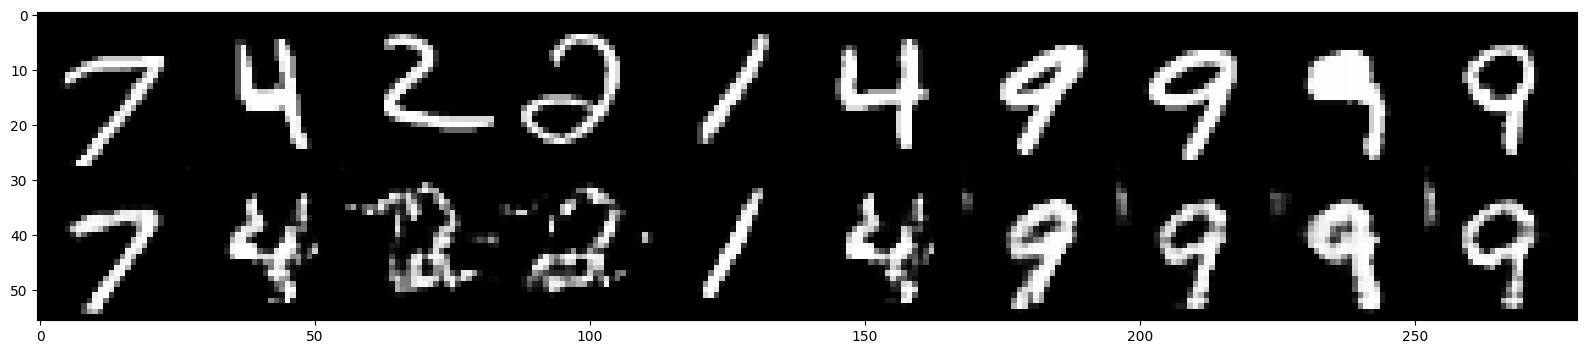

epochs:  28 loss:  0.17841081 11.910242 0.0023729058


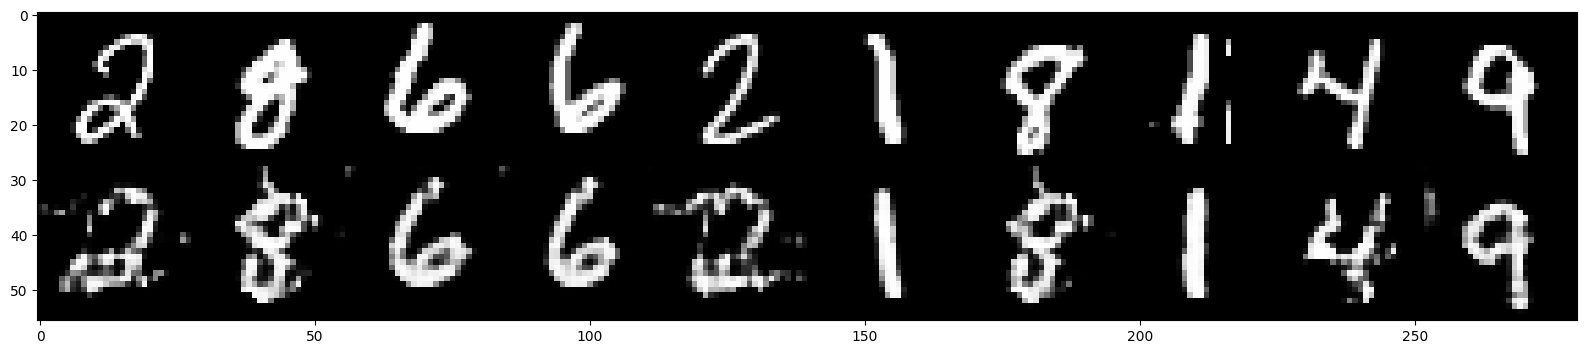

epochs:  29 loss:  0.17392865 11.694114 0.0015410762


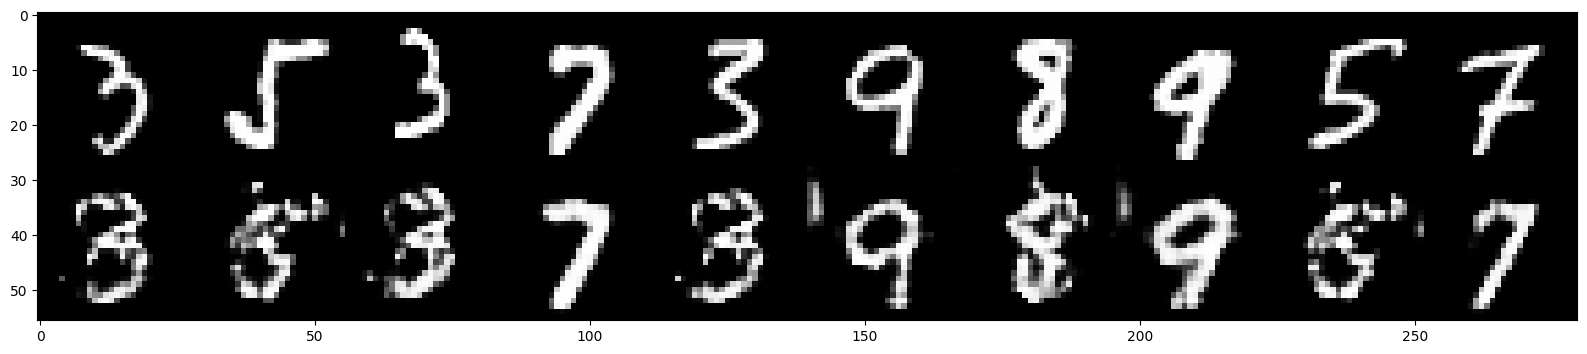

epochs:  30 loss:  0.18352464 11.53355 0.0016409825


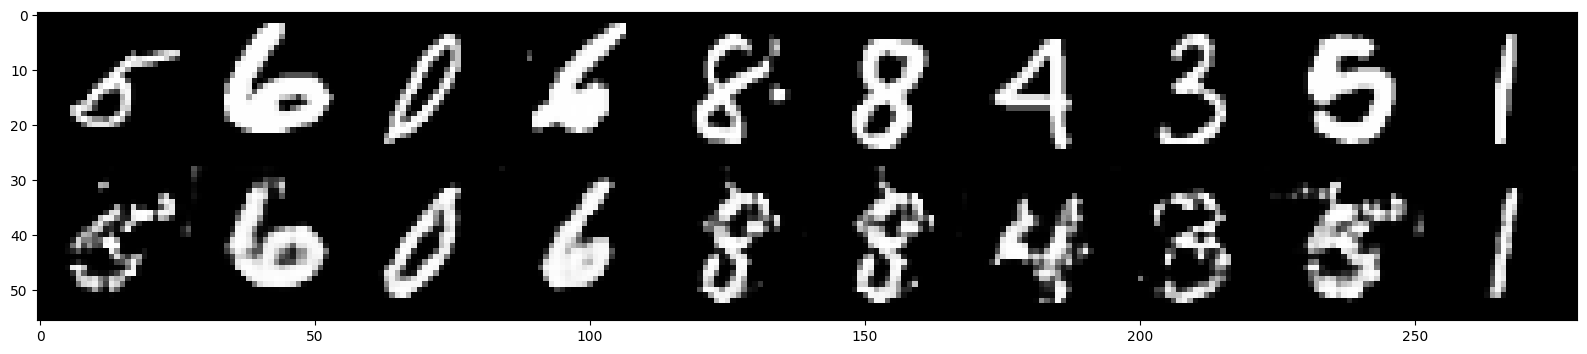

epochs:  31 loss:  0.16176388 11.924763 0.0025341988


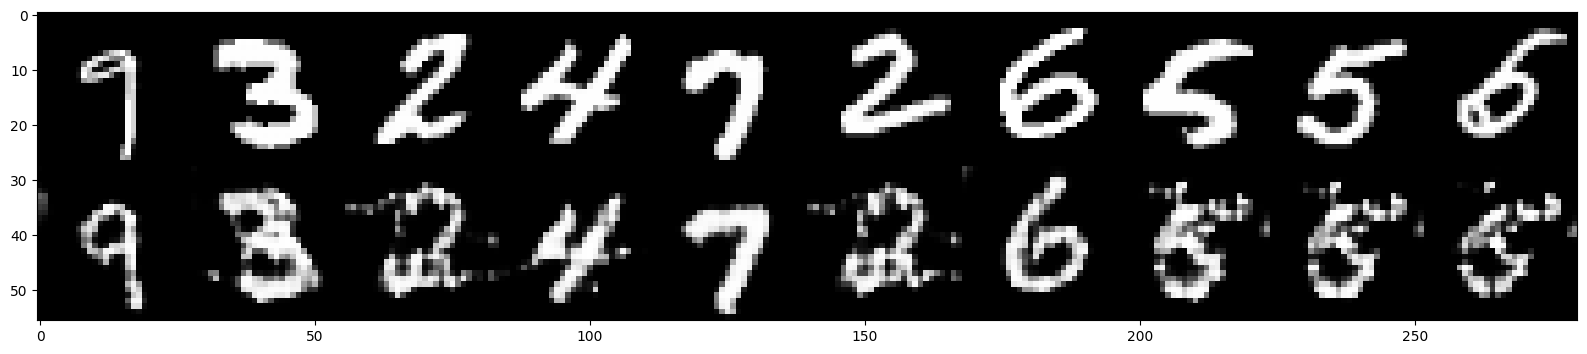

epochs:  32 loss:  0.17183505 11.810145 0.0014372132


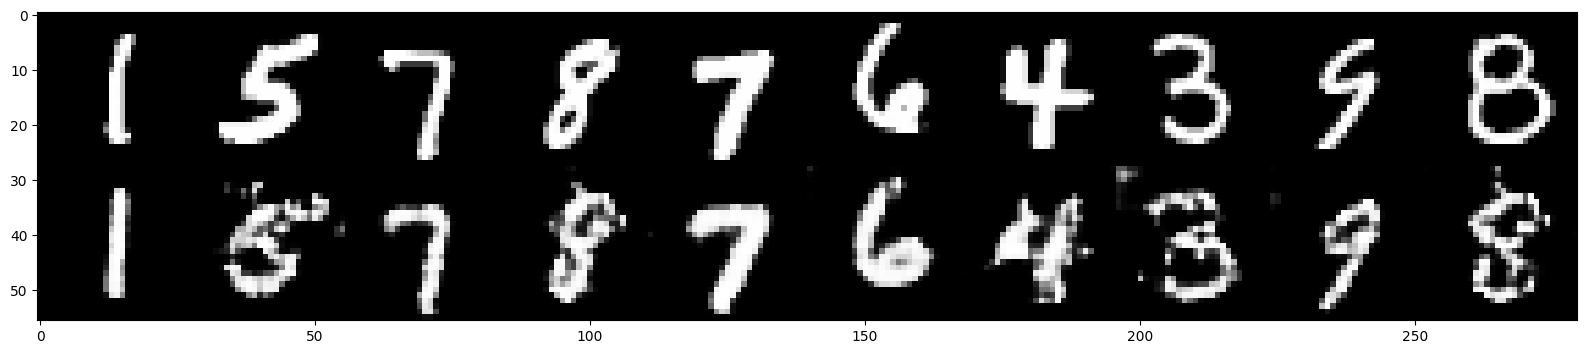

epochs:  33 loss:  0.17453966 11.851807 0.0021842835


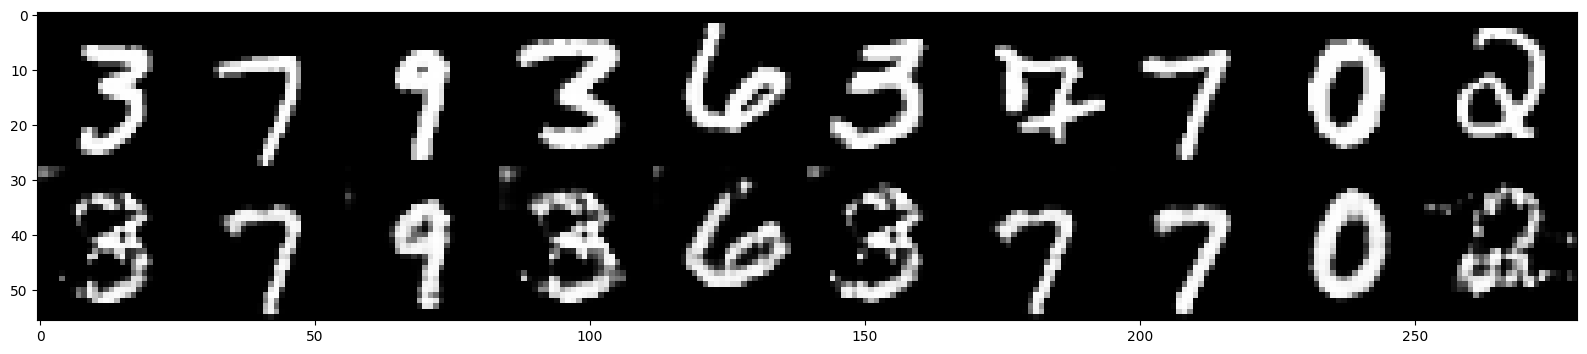

epochs:  34 loss:  0.17833816 11.83807 0.0038654292


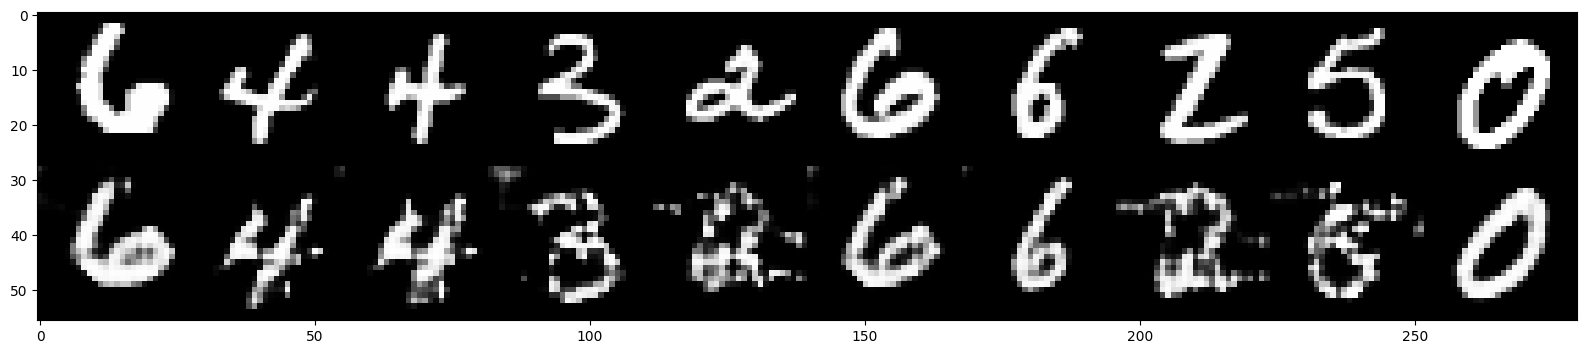

epochs:  35 loss:  0.16972616 11.719212 0.00091847026


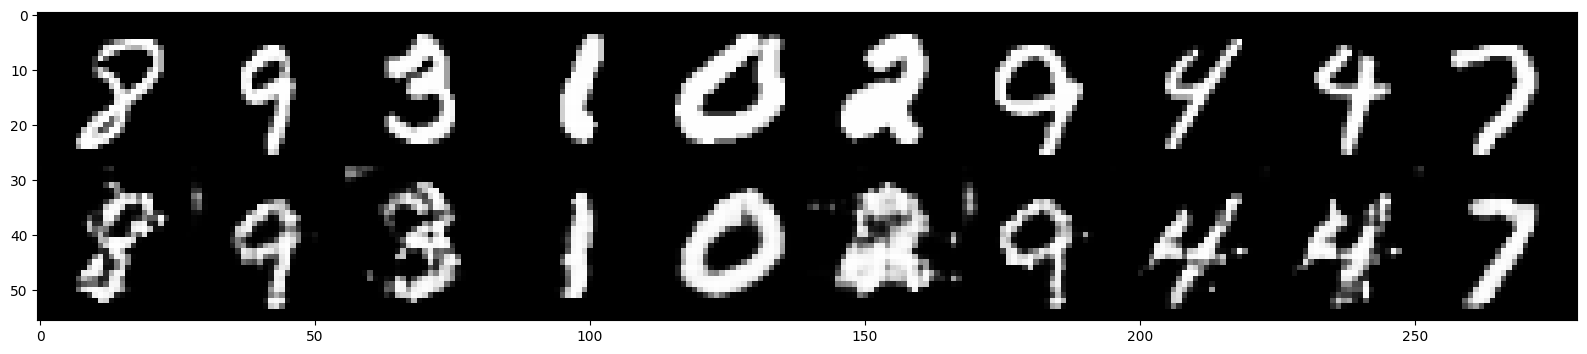

epochs:  36 loss:  0.17912757 11.683749 0.0024018115


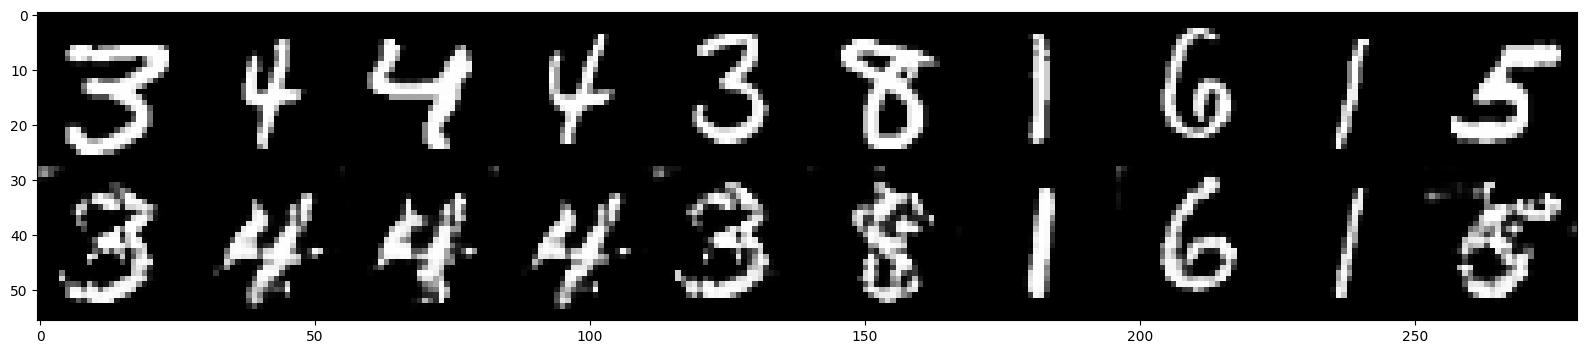

epochs:  37 loss:  0.17388749 11.546896 0.003135702


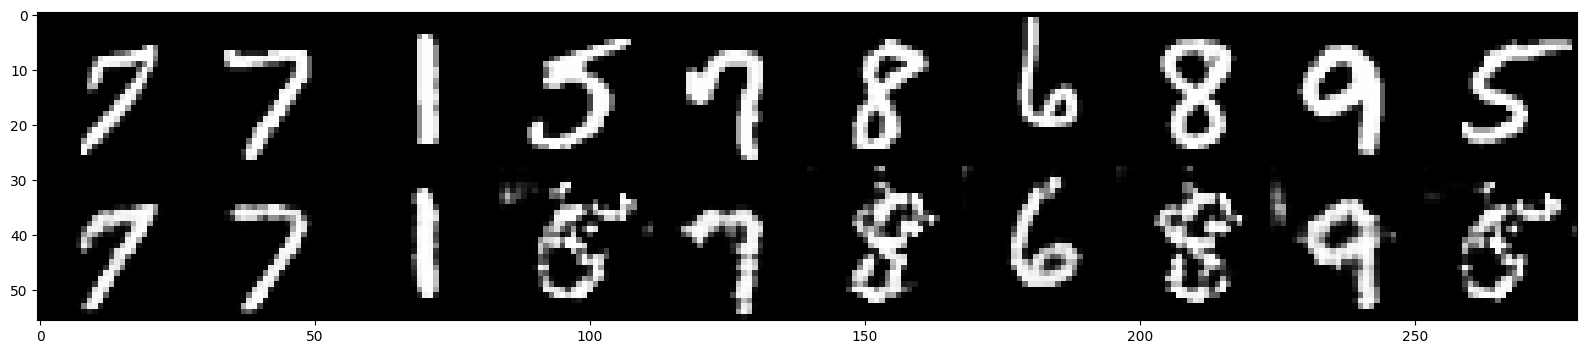

epochs:  38 loss:  0.18147758 11.427715 0.00079143775


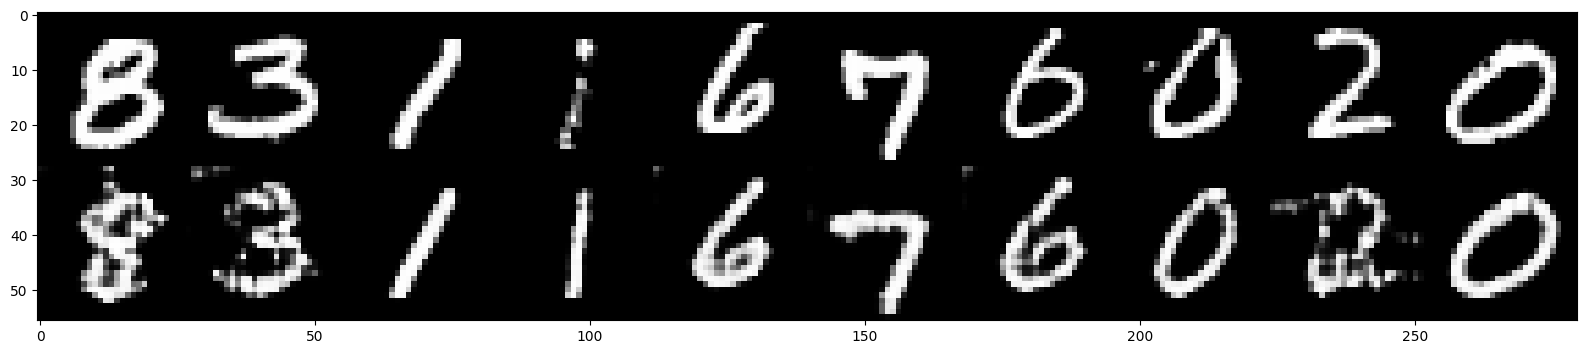

epochs:  39 loss:  0.175758 11.39592 0.0009027611


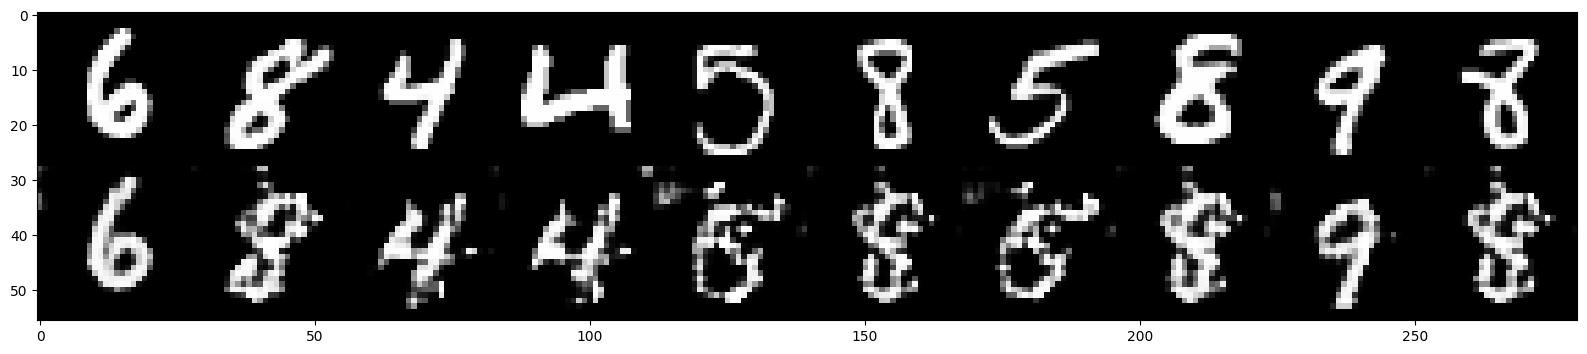

epochs:  40 loss:  0.19033591 11.477634 0.005956781


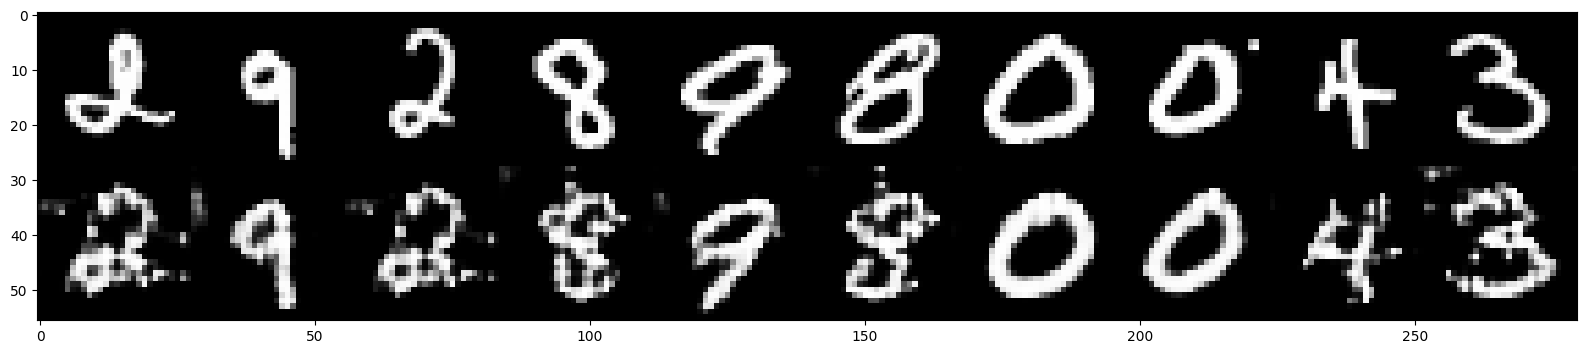

epochs:  41 loss:  0.18402877 11.393189 0.0007577524


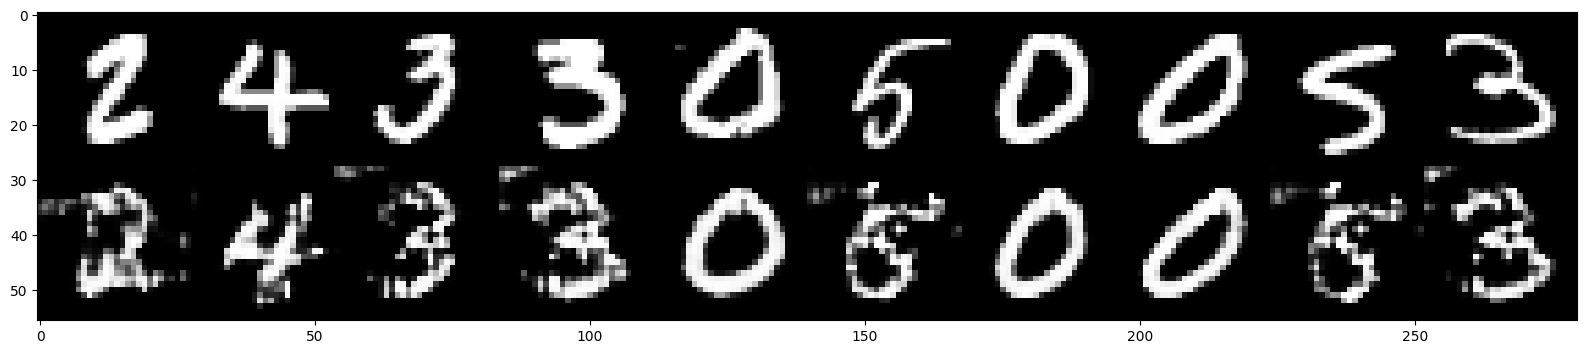

epochs:  42 loss:  0.18783017 11.575116 0.0011516515


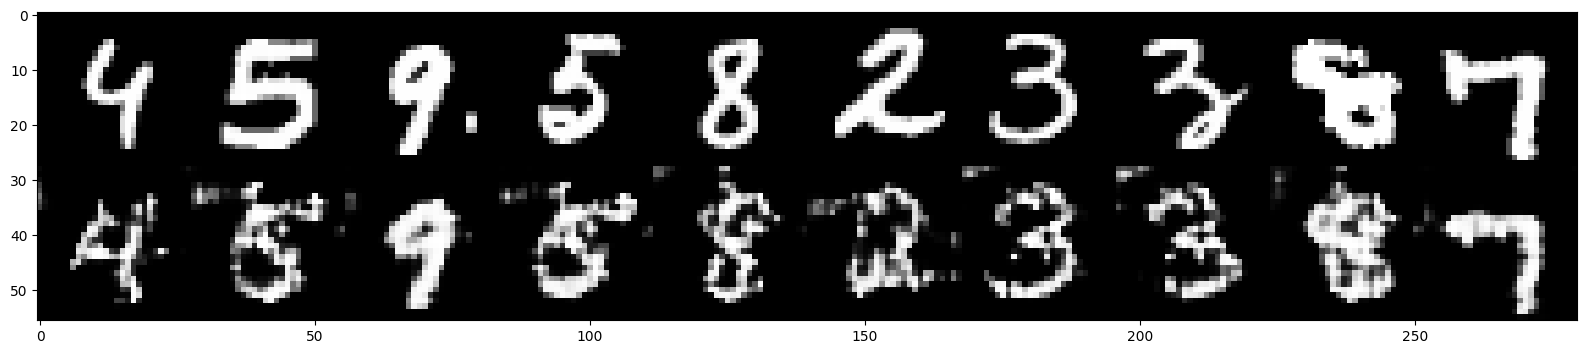

epochs:  43 loss:  0.1899725 11.202116 0.00076996145


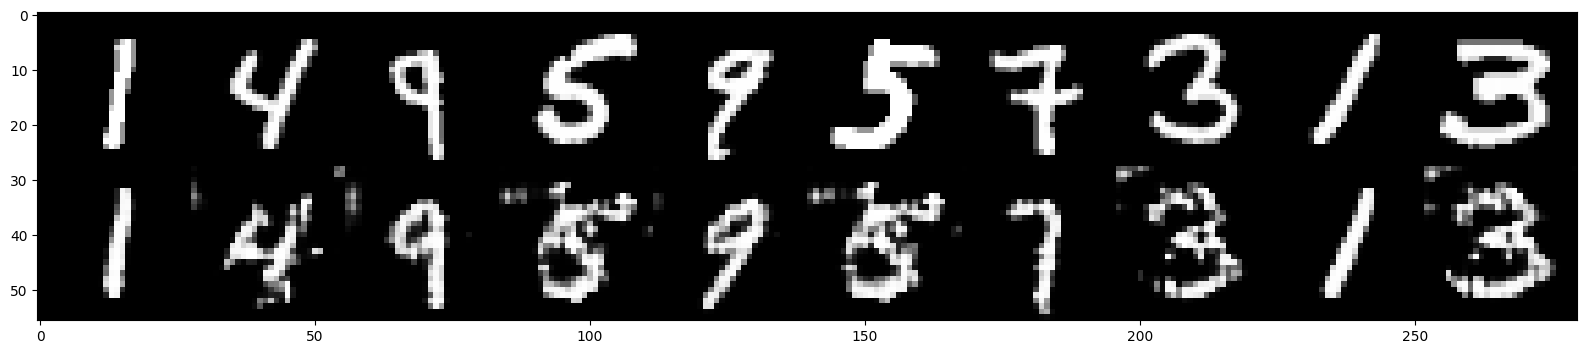

epochs:  44 loss:  0.1876078 11.371643 0.0037727973


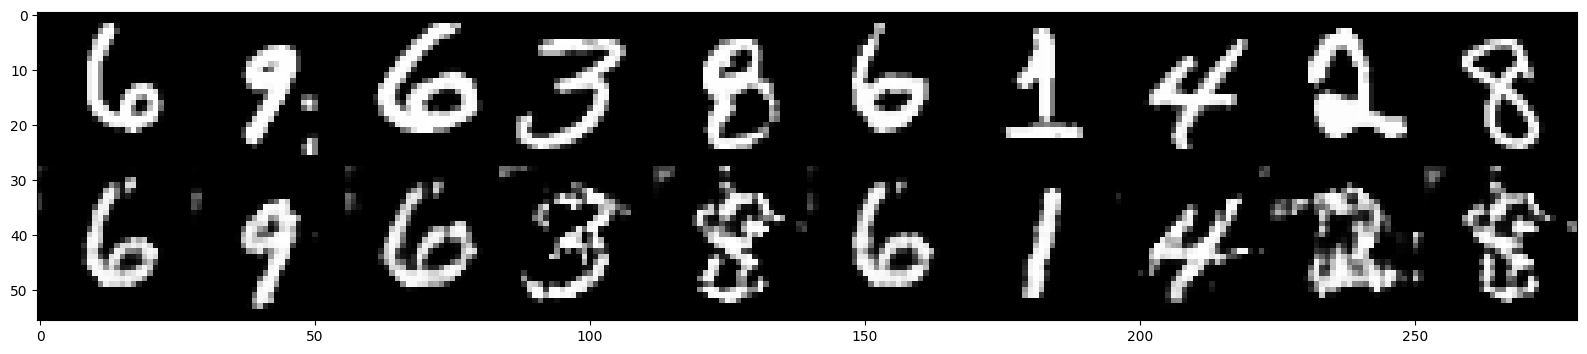

epochs:  45 loss:  0.19593297 11.269736 0.00086574163


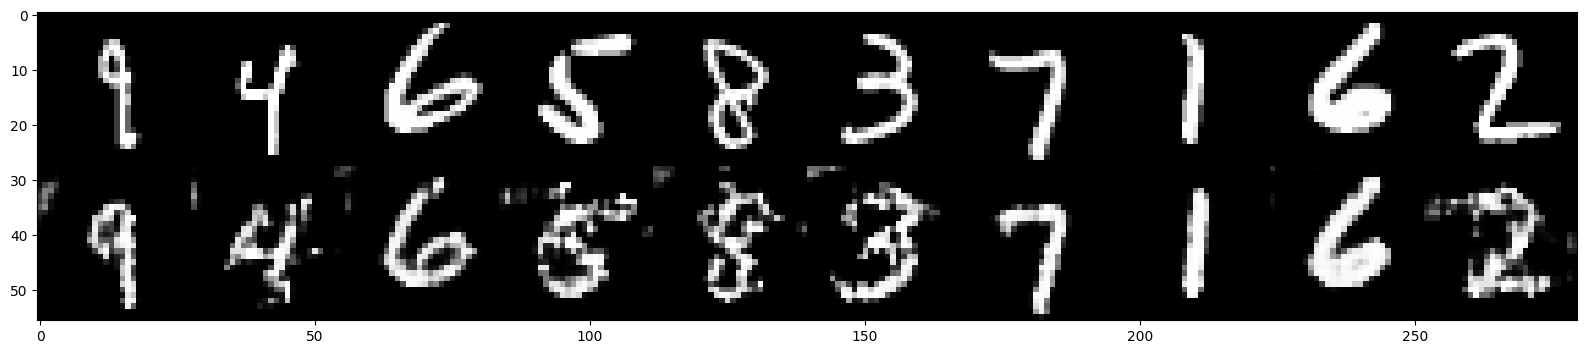

epochs:  46 loss:  0.21230783 11.367017 0.001988454


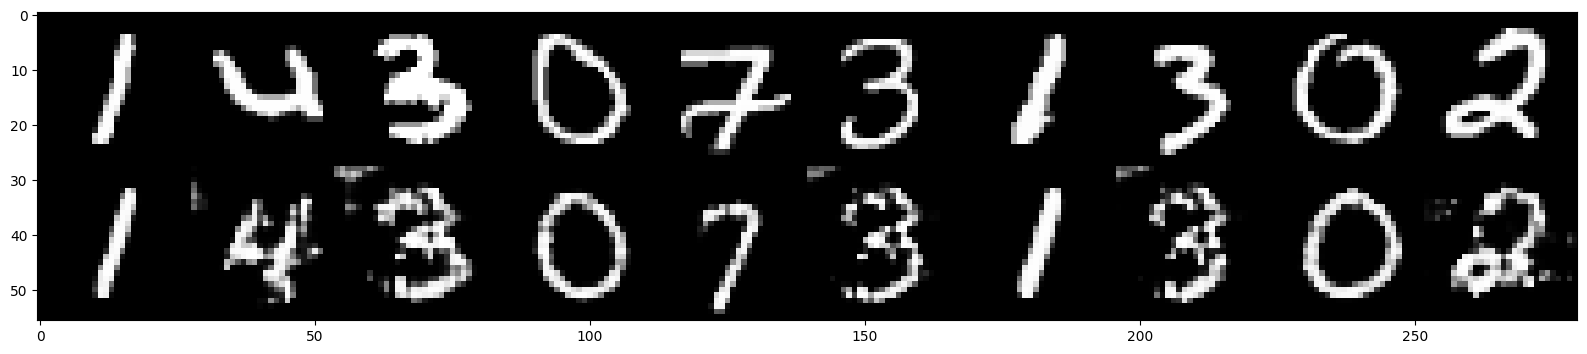

epochs:  47 loss:  0.19937779 11.240656 0.0010705438


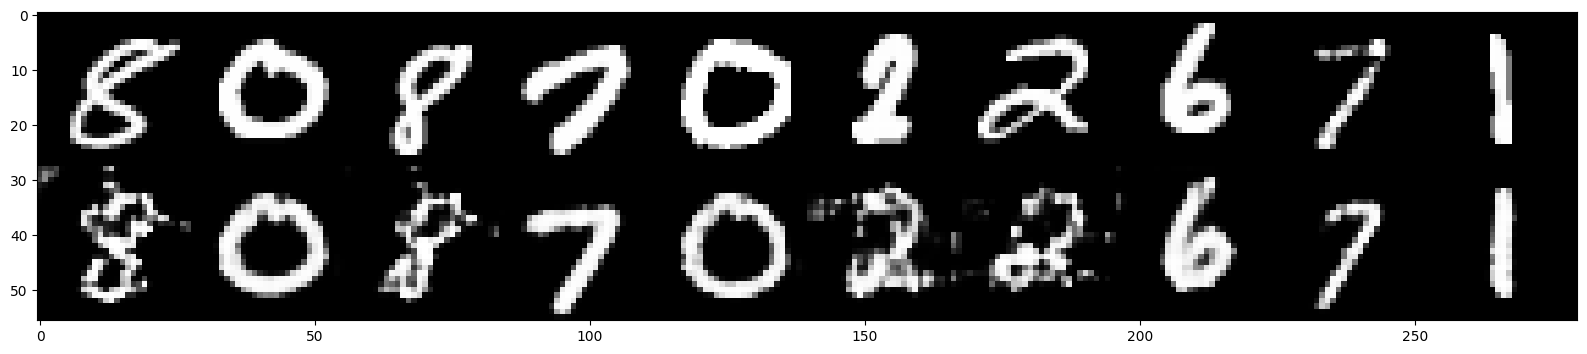

epochs:  48 loss:  0.18672101 11.220265 0.0014053931


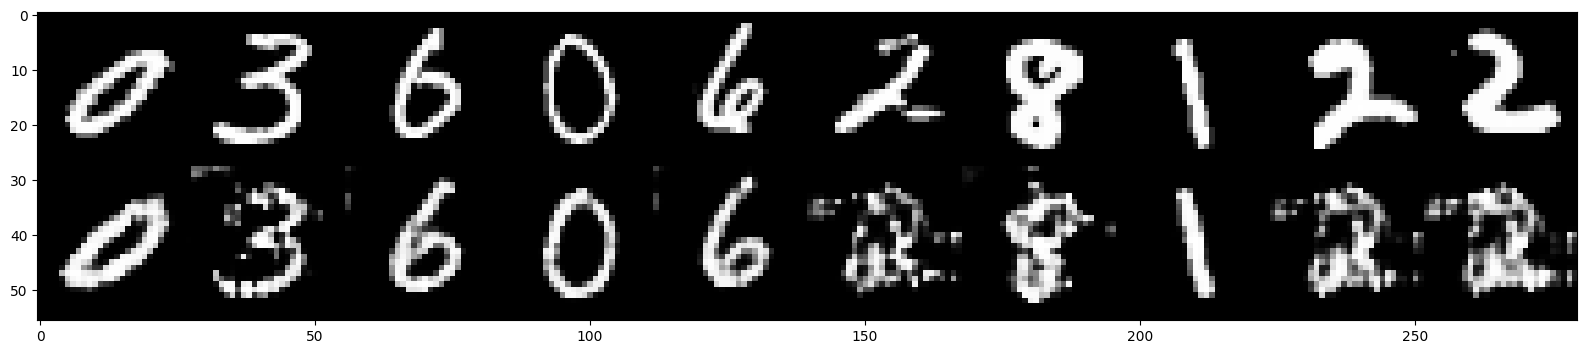

epochs:  49 loss:  0.19858918 11.299911 0.00047760777


In [11]:
vae_step = 4
dis_step = 1

steps = int(len(x_train) / (batch_size * (vae_step + dis_step)))

epochs = 50


for e in range(epochs):
    for i in range(steps):

        for j in range(dis_step):
            xb, yb = next(train_batches_it)
            zp = np.random.randn(batch_size, latent_dim)
            l_g = step_d(xb, yb, zp)



        for j in range(vae_step):
            xb, yb = next(train_batches_it)
            zp = np.random.randn(batch_size, latent_dim)
            l_p, zx, l_d, l_g = step(xb, yb, zp)


    display_digits()
    print('epochs: ', e, 'loss: ', l_p, l_d, l_g)

In [75]:
def display_z(my_label = 0):
    n = 1
    num = 1

    zp = np.random.randn(1, latent_dim)

    my_label_one = [[0 for i in range(10)]]
    my_label_one[0][my_label] = 1

    decoded = sess.run([decoded_z], feed_dict={z:zp, lbl:my_label_one, K.learning_phase():0})

    digit_size = 28

    figure = np.zeros((digit_size * num, digit_size * n))

    for i in range(n):
        figure[0: digit_size,
                   i * digit_size: (i + 1) * digit_size] = decoded[i].reshape(digit_size, digit_size)


    plt.figure(figsize=(2*n, 2*num))
    plt.imshow(figure, cmap='Greys_r')

    plt.show()

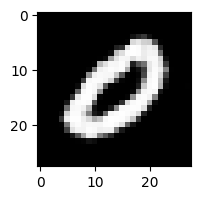

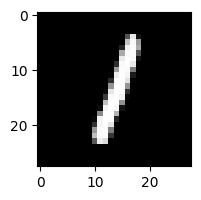

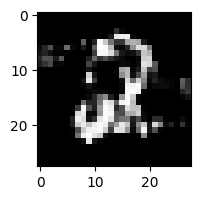

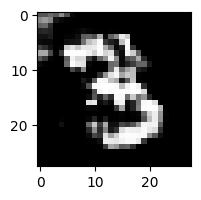

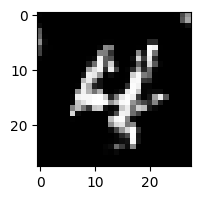

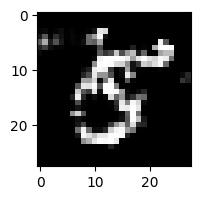

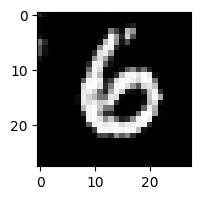

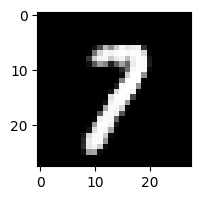

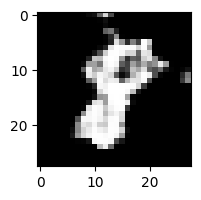

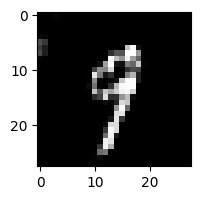

In [76]:
display_z(0)
display_z(1)
display_z(2)
display_z(3)
display_z(4)
display_z(5)
display_z(6)
display_z(7)
display_z(8)
display_z(9)